## 统计分析

通过指定统计分析字段，得到每个特征的p_value，所有的p_value计算都是基于Ttest计算。支持指定不同的分组`group`，例如train、val、test等分组统计。

对于两大类不同的特征

1. 离散特征，统计数量以及占比。
2. 连续特征，统计均值、方差。

In [8]:
import pandas as pd
import numpy as np
from onekey_algo import OnekeyDS as okds
from onekey_algo import get_param_in_cwd
from onekey_algo.custom.utils import print_join_info

task = get_param_in_cwd('task_column') or 'label'
p_value = get_param_in_cwd('p_value') or 0.05
# 修改成自己临床数据的文件。
test_data = pd.read_csv(get_param_in_cwd('clinic_file'))
stats_columns_settings = get_param_in_cwd('stats_columns')
continuous_columns_settings = get_param_in_cwd('continuous_columns')
mapping_columns_settings = get_param_in_cwd('mapping_columns')
test_data = test_data[[c for c in test_data.columns if c != task]]
test_data['ID'] = test_data['ID'].map(lambda x: f"{x}.nii.gz" if not (f"{x}".endswith('.nii.gz') or  f"{x}".endswith('.nii')) else x)
group_info = pd.read_csv(get_param_in_cwd('label_file'))

print_join_info(test_data, group_info)
test_data = pd.merge(test_data, group_info, on='ID', how='inner')
test_data

[2024-06-11 15:34:48 - __init__.py:  55]	INFO	ID特征完全匹配！


,ID,PSA,Gleason,Age,group,label
0,302.nii.gz,16.196,7.0,67.0,train,0
1,194.nii.gz,0.440,6.0,81.0,train,0
2,333.nii.gz,9.890,6.0,59.0,train,0
3,072.nii.gz,44.144,6.0,79.0,train,0
4,288.nii.gz,0.020,8.0,70.0,train,1
...,...,...,...,...,...,...
395,312.nii.gz,14.715,7.0,66.0,test,1
396,242.nii.gz,0.900,6.0,59.0,test,0
397,098.nii.gz,8.433,8.0,68.0,test,1
398,420.nii.gz,86.272,8.0,82.0,test,1


In [9]:
test_data['group'].value_counts()

train    280
test     120
Name: group, dtype: int64

# 特征名称处理

去掉所有特征名称中的特殊字符。

In [10]:
import re

def map_cnames(x):
    x = re.split('[（|(]', x)[0]
    x = x.replace('-', '_').replace(' ', '_').replace('>', '').replace('/', '_')
    return x.strip()

test_data.columns = list(map(map_cnames, test_data.columns))
test_data.columns

Index(['ID', 'PSA', 'Gleason', 'Age', 'group', 'label'], dtype='object')

# 分析数据

获取待分析的特征列名，如未制定，自动侦测。

In [11]:
stats_columns = [c for c in stats_columns_settings or list(test_data.columns[1:-2]) if c not in ['Degree_of_tumor_regression']]
test_data = test_data.copy()[['ID'] + stats_columns + ['group'] + task]
test_data#['group'].value_counts()

,ID,PSA,Gleason,Age,group,label
0,302.nii.gz,16.196,7.0,67.0,train,0
1,194.nii.gz,0.440,6.0,81.0,train,0
2,333.nii.gz,9.890,6.0,59.0,train,0
3,072.nii.gz,44.144,6.0,79.0,train,0
4,288.nii.gz,0.020,8.0,70.0,train,1
...,...,...,...,...,...,...
395,312.nii.gz,14.715,7.0,66.0,test,1
396,242.nii.gz,0.900,6.0,59.0,test,0
397,098.nii.gz,8.433,8.0,68.0,test,1
398,420.nii.gz,86.272,8.0,82.0,test,1


# 特征队列映射

所有需要进行特征映射的队列，range未制定，可以进行自动判断。

In [12]:
mapping_columns = mapping_columns_settings or [c for c in test_data.columns[1:-2] if test_data[c].dtype == object]
mapping_columns

[]

# 数据映射

针对所有非数值形式的数据，可以进行类别映射。

In [13]:
from onekey_algo.custom.utils import map2numerical

data, mapping = map2numerical(test_data, mapping_columns=mapping_columns)
mapping

{}

# 连续特征列

自动识别所有可能的连续特征列。如果列不是整数，或者列的元素超过5个，则呗认定为连续特征。

In [14]:
from onekey_algo.custom.components.comp1 import fillna

test_data = fillna(test_data, fill_mod='50%')
continuous_columns = []
for col in test_data.columns:
    if test_data[col].apply(lambda x: x.is_integer() if isinstance(x, float) else False).all():
        test_data[col] = test_data[col].astype(int)

for c in stats_columns:
#     print(c, np.unique(test_data[c]), test_data[c].dtype)
    if len(np.unique(test_data[c])) > 5 or not np.int8 <= test_data[c].dtype <= np.int64:
        continuous_columns.append(c)
        
continuous_columns = continuous_columns_settings or continuous_columns
continuous_columns = [c for c in continuous_columns if c not in ('differentation')]
# continuous_columns = []

In [15]:
continuous_columns

['PSA', 'Age']

# 缺失值填充

In [16]:
import os
os.makedirs('data', exist_ok=True)
data = test_data
data.to_csv('data/clinical.csv', index=False)
data

,ID,PSA,Gleason,Age,group,label
0,302.nii.gz,16.196,7,67,train,0
1,194.nii.gz,0.440,6,81,train,0
2,333.nii.gz,9.890,6,59,train,0
3,072.nii.gz,44.144,6,79,train,0
4,288.nii.gz,0.020,8,70,train,1
...,...,...,...,...,...,...
395,312.nii.gz,14.715,7,66,test,1
396,242.nii.gz,0.900,6,59,test,0
397,098.nii.gz,8.433,8,68,test,1
398,420.nii.gz,86.272,8,82,test,1


In [17]:
data['group'].value_counts()

train    280
test     120
Name: group, dtype: int64

### 统计分析

支持两种格式数据，分别对应`pretty`参数的`True`和`False`, 当为`True`时，输出的是表格模式，反之则为dict数据。

```python
def clinic_stats(data: DataFrame, stats_columns: Union[str, List[str]], label_column='label',
                 group_column: str = None, continuous_columns: Union[str, List[str]] = None,
                 pretty: bool = True) -> Union[dict, DataFrame]:
    """

    Args:
        data: 数据
        stats_columns: 需要统计的列名
        label_column: 二分类的标签列，默认`label`
        group_column: 分组统计依据，例如区分训练组、测试组、验证组。
        continuous_columns: 那些列是连续变量，连续变量统计均值方差。
        pretty: bool, 是否对结果进行格式美化。

    Returns:
        stats DataFrame or json

    """
```

In [18]:
from onekey_algo.custom.components.stats import clinic_stats

pd.set_option('display.max_rows', None)
stats = clinic_stats(data, 
                     stats_columns= stats_columns,
                     label_column=task[0], 
                     group_column='group', 
                     continuous_columns= continuous_columns, 
                     pretty=True, verbose=False)
stats

,feature_name,train-label=ALL,train-label=0,train-label=1,pvalue,test-label=ALL,test-label=0,test-label=1,pvalue
0,PSA,44.08±108.46,32.74±78.20,47.44±115.86,0.023,71.81±228.91,57.05±180.13,76.95±244.32,0.131
1,Age,70.05±7.19,70.25±8.46,70.00±6.79,0.616,71.08±7.82,68.87±8.90,71.84±7.31,0.037
0,Gleason,,,,<0.001,,,,<0.001
1,6,44(15.71),20(31.25),24(11.11),,22(18.33),14(45.16),8(8.99),
2,7,129(46.07),28(43.75),101(46.76),,52(43.33),13(41.94),39(43.82),
3,8,55(19.64),12(18.75),43(19.91),,26(21.67),2(6.45),24(26.97),
4,9,47(16.79),3(4.69),44(20.37),,18(15.00),2(6.45),16(17.98),
5,10,5(1.79),1(1.56),4(1.85),,2(1.67),null,2(2.25),


In [19]:
from onekey_algo.custom.components.stats import clinic_stats

pd.set_option('display.max_rows', None)
stats = clinic_stats(data, 
                     stats_columns= stats_columns,
                     label_column='group', 
                     group_column=None, 
                     continuous_columns= continuous_columns, 
                     pretty=True, verbose=False)
stats.to_csv('stats_all.csv', index=False, encoding='utf_8_sig')
stats

,feature_name,-label=ALL,-label=test,-label=train,pvalue
0,PSA,52.40±154.97,71.81±228.91,44.08±108.46,0.459
1,Age,70.36±7.39,71.08±7.82,70.05±7.19,0.107
0,Gleason,,,,0.934
1,6,66(16.50),22(18.33),44(15.71),
2,7,181(45.25),52(43.33),129(46.07),
3,8,81(20.25),26(21.67),55(19.64),
4,9,65(16.25),18(15.00),47(16.79),
5,10,7(1.75),2(1.67),5(1.79),


# 单因素多因素分析

单因素，步进多因素分析
```python
def uni_multi_variable_analysis(data: pd.DataFrame, features: Union[str, List[str]] = None, label_column: str = 'label',
                                need_norm: Union[bool, List[bool]] = False, alpha=0.1,
                                p_value4multi: float = 0.05, save_dir: Union[str] = None, prefix: str = '',
                                **kwargs):
    """
    单因素，步进多因素分析，使用p_value4multi参数指定多因素分析的阈值
    Args:
        data: 数据
        features: 需要分析的特征，默认除了ID和label_column列，其他的特征都进行分析。
        label_column: 目标列
        need_norm: 是否标准化所有分析的数据, 默认为False
        alpha: CI alpha, alpha/2 %；默认为0.1即95% CI
        p_value4multi: 参数指定多因素分析的阈值，默认为0.05
        save_dir: 保存位置
        prefix: 前缀
        **kwargs:

    Returns:

    """
 ```

,Log(OR),lower 95%CI,upper 95%CI,OR,OR lower 95%CI,OR upper 95%CI,p_value
feature_name,,,,,,,
PSA,0.000,-0.000,0.001,1.000,1.000,1.001,0.342
Gleason,0.094,0.054,0.135,1.099,1.055,1.145,0.000
Age,-0.001,-0.007,0.005,0.999,0.993,1.005,0.804


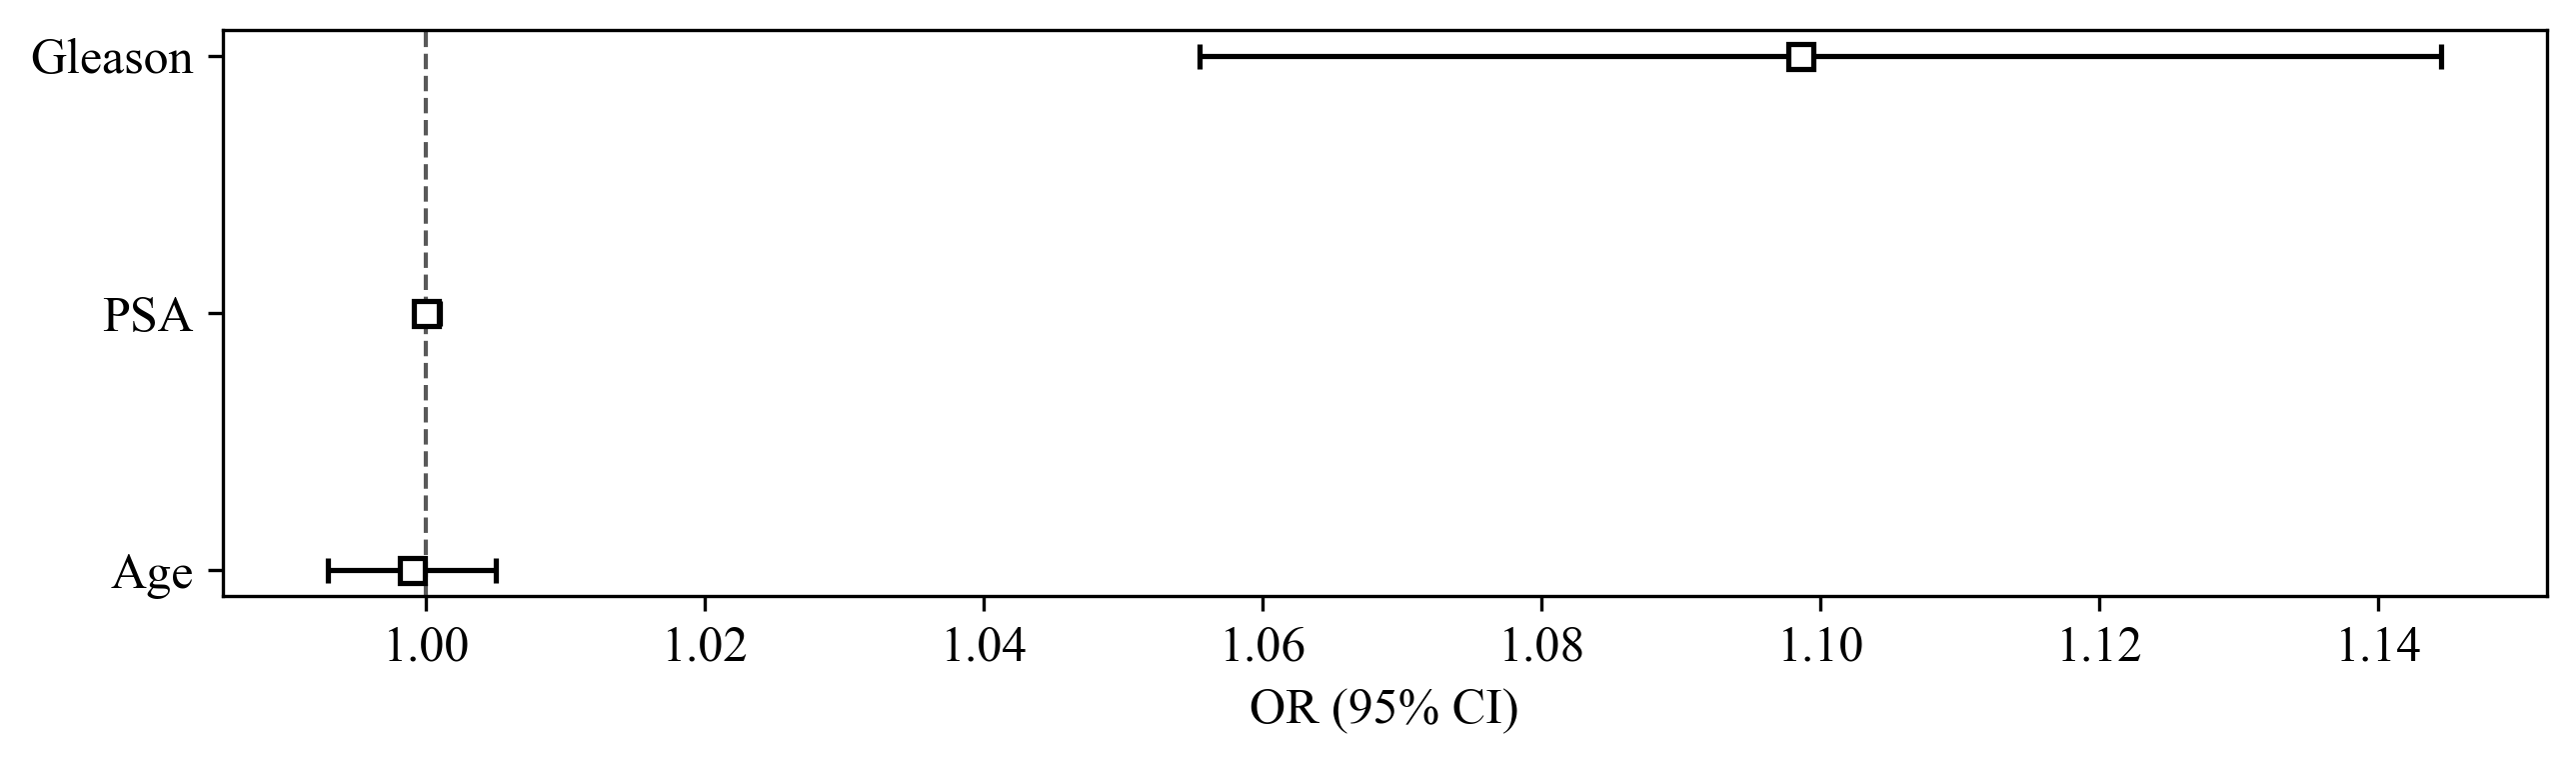

,Log(OR),lower 95%CI,upper 95%CI,OR,OR lower 95%CI,OR upper 95%CI,p_value
feature_name,,,,,,,
Gleason,0.094,0.054,0.135,1.099,1.055,1.145,0.0


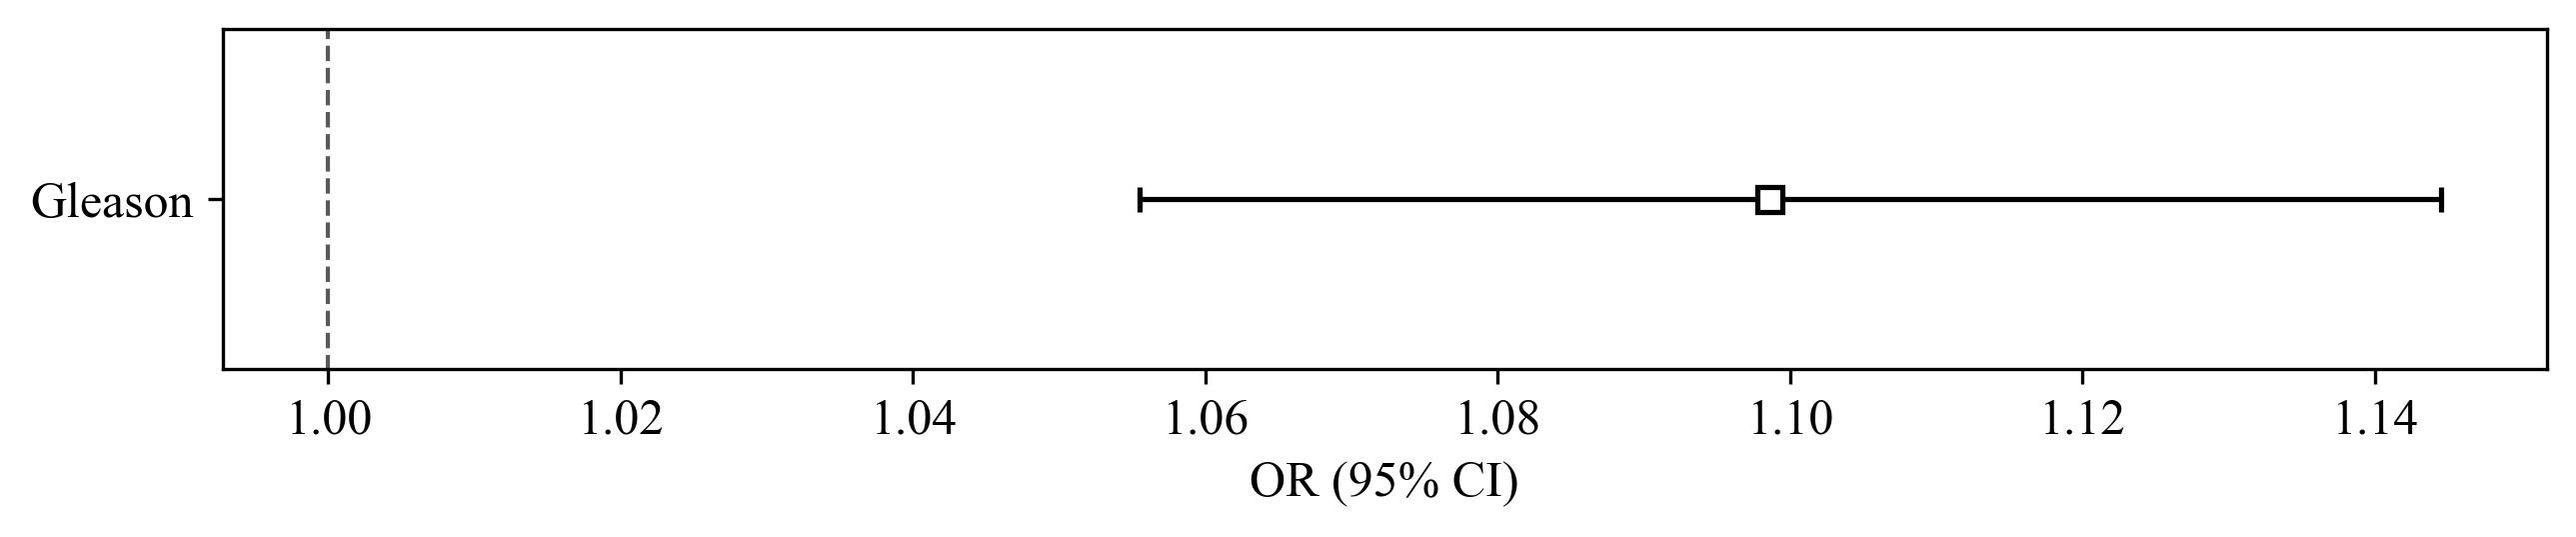

In [20]:
from onekey_algo.custom.components.comp1 import uni_multi_variable_analysis                        

r = uni_multi_variable_analysis(data[data['group'] == 'train'], stats_columns, save_dir='img', p_value4multi=p_value, algo='ols',
                                hazard_ratios=True, label_column=task[0])

In [21]:
uni_v = pd.read_csv('img/multivariable_reg.csv')
uni_v = uni_v[uni_v['p_value'] <= 0.05]
sel_data = data[['ID'] + list(uni_v['feature_name']) + ['group'] + task]
sel_data.to_csv('clinic_sel.csv', index=False)
sel_data

,ID,Gleason,group,label
0,302.nii.gz,7,train,0
1,194.nii.gz,6,train,0
2,333.nii.gz,6,train,0
3,072.nii.gz,6,train,0
4,288.nii.gz,8,train,1
5,208.nii.gz,9,train,1
6,156.nii.gz,6,train,0
7,109.nii.gz,7,train,1
8,358.nii.gz,6,train,1
9,228.nii.gz,7,train,0


In [22]:
uni = pd.read_csv(f'img/univariable_reg.csv')
uni = uni[[c for c in uni if ('OR' in c and 'Log' not in c) or c in ['feature_name', 'p_value']]]
multi = pd.read_csv('img/multivariable_reg.csv')
multi = multi[[c for c in uni if ('OR' in c and 'Log' not in c) or c in ['feature_name', 'p_value']]]
info = pd.merge(uni, multi, on='feature_name', how='left', suffixes=['_UNI', '_MULTI']).applymap(lambda x: '' if pd.isna(x) else x)
info = info.applymap(lambda x: "<0.05" if isinstance(x, (int, float)) and x < 0.05 else x)
display(info)

,feature_name,OR_UNI,OR lower 95%CI_UNI,OR upper 95%CI_UNI,p_value_UNI,OR_MULTI,OR lower 95%CI_MULTI,OR upper 95%CI_MULTI,p_value_MULTI
0,Age,0.999,0.993,1.005,0.804,,,,
1,PSA,1.000,1.000,1.001,0.342,,,,
2,Gleason,1.099,1.055,1.145,<0.05,1.099,1.055,1.145,<0.05
